In [1]:
import os
import boto3
import sagemaker
from sagemaker import get_execution_role
from PIL import Image

import math

import keras
from keras.applications.inception_v3 import InceptionV3
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import LeakyReLU, Input
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import SGD
from keras import metrics
from keras.regularizers import l2

import keras.backend as K

Using TensorFlow backend.


# Flow
<br>

 1) local에서 원본 데이터 폴더 내 이미지를 train, validation, test 세 폴더로 데이터 분리

 2) aws s3에서 sagemaker로 이미지 파일 전송
 
 3) 이미지 EDA 및 전처리
 
 4) 이미지 분류 CNN 모델 중 하나인 InceptionV3 모델을 활용한 한식 이미지 분류 CNN 모델 만들기
 
 5) validation set에서 모델 평가 (기준 : accuracy, confusion_matrix 시각화)
  
 6) test set에서 accuracy 최종 확인
 
 7) h5 model을 tflite 모델로 변환
 
 8) FireBase에 모델 올릴 때 용량 제한 문제 발생 
 
 9) 가벼운 용량의 MobileNetV2 모델로 (4, 5, 6, 7 과정 재 수행)
 
 10) Firebase에 MobileNetV2 모델 개시
 
 ----
 
### Summary

A) InceptionV3 기반 모델

- max accuracy : <span style="color:red">train -> 97.7%, val -> 87.1%, test -> 90.0% </span>


- 모델 용량 : <span style="color:blue"> h5 model : 178MB, tflite model : 88.3MB </span>


B) MobileNetV2  기반 모델

- max accruacy : <span style="color:red">train -> 96.1%, val -> 82.4%, test -> 85.1% </span>


- 모델 용량 : <span style="color:blue"> h5 model : 20MB, tflite model : 9MB </span>


#### test set 정확도는 약 5% 더 부족하지만, 용량 면에서 FireBase와의 연동성을 고려해 앱에서는 MobileNetV2를 사용!
 
---

### 1) local에서 원본 데이터 폴더 내 이미지를 train, validation, test 세 폴더로 데이터 분리
<br>

원본 데이터 출처 : http://www.aihub.or.kr/content/140 (AIHub) 의 한식 데이터
<br>

<b> 대분류 12개, 소분류 150개, 각 종류별 1000개의 데이터, 용량 15GB</b>


![title](images/150koreanFoods.png)

<b>train, validaton, test 를 8:1:1의 비율로 split (local에서 수행)</b>

In [28]:
# original_dataset_dir = 'C:/Users/ASUS/Desktop/음식'
# base_dir = 'C:/Users/ASUS/Desktop/final_food'

# os.mkdir(base_dir)

# train_dir = os.path.join(base_dir, 'train')
# os.mkdir(train_dir)


# validation_dir = os.path.join(base_dir, 'validation')
# os.mkdir(validation_dir)

# test_dir = os.path.join(base_dir, 'test')
# os.mkdir(test_dir)

# random.seed = 42

# file_list = os.listdir(original_dataset_dir)

# for each in file_list: # 대분류
#     big = os.path.join(original_dataset_dir, each)
#     big_class = os.listdir(big)
    
#     for food_name in big_class: # 소분류
        
#         train_each = os.path.join(train_dir, food_name)
#         os.mkdir(train_each)
        
#         val_each = os.path.join(validation_dir, food_name)
#         os.mkdir(val_each)
        
#         test_each = os.path.join(test_dir, food_name)
        
#         os.mkdir(test_each)
        
#         small_list = os.path.join(big, food_name)
        
#         foods = os.listdir(small_list)
        
#         for i, each_food in enumerate(foods):
#             if i == 0 or i == len(foods) - 1:
#                 continue  
#             if i <= 800: # train 80%
#                 src = os.path.join(small_list, each_food)
#                 dst = os.path.join(train_each, each_food)
#                 shutil.copyfile(src, dst)
#             elif i <= 900: # val 10%
#                 src = os.path.join(small_list, each_food)
#                 dst = os.path.join(val_each, each_food)
#                 shutil.copyfile(src, dst)
#             else: # test 10%
#                 src = os.path.join(small_list, each_food)
#                 dst = os.path.join(test_each, each_food)
#                 shutil.copyfile(src, dst)
                
                
            
#                 print("    ", each_food)

### 1) aws s3에서 sagemaker로 이미지 파일 전송

In [3]:
# get_execution_role 함수는 노트북 인스턴스 생성 시점에 생성한 IAM 역할을 가져옴!
role = get_execution_role()
print(role)
bucket = 'sagemaker-encorefood' # 한식 이미지 저장된 버킷

arn:aws:iam::013461250319:role/service-role/AmazonSageMaker-ExecutionRole-20190129T084489


In [4]:
# 150개의 한식을 리스트로 담음
client = boto3.client('s3')
foods_result = client.list_objects(Bucket=bucket, Prefix='train/', Delimiter='/')
# ex) train/가지볶음/ -> 앞 6글자 제거 및 뒤 / 제거
food_list = [o.get('Prefix')[6:].replace('/', '') for o in foods_result.get('CommonPrefixes')]
print("food_list의 길이는 ==== ",len(food_list))

food_list의 길이는 ====  150


In [5]:
## 실제 S3에서 sagemaker로 이동하는 코드

# 1) 주피터 노트북 현재 경로
os.getcwd()

base_dir = os.getcwd() + '/food_data'

if not (os.path.isdir(base_dir)):
    os.mkdir(base_dir)

# 2) 경로 설정
train_dir = os.path.join(base_dir, 'train' )
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

total = [train_dir, val_dir, test_dir]

# 3) 설정한 경로에 폴더 생성

# if not (os.path.isdir(train_dir)):
#     os.mkdir(train_dir)
    
# if not (os.path.isdir(val_dir)):
#     os.mkdir(val_dir)

# if not (os.path.isdir(test_dir)):
#     os.mkdir(test_dir)
    
# # 4) s3 저장소에서 train, validation, test 폴더로 이미지 전송

# for _, each_dir in enumerate(total):
    
#     for i, food in enumerate(food_list):
#         img_result = client.list_objects(Bucket = bucket, 
#                                          Prefix='{}/{}/'.format(each_dir.split('/')[-1], food), Delimiter='/')

#         # test 폴더에 각 음식 이미지가 들어갈 폴더를 생성!
#         each_food_dir = os.path.join(each_dir, food)
#         os.mkdir(each_food_dir)
#         print(each_food_dir)
#         # 생성한 폴더 내에 각 음식 이미지를 저장!
#         food_img_list = [each['Key'] for each in img_result['Contents']]
#         for j, each in enumerate(food_img_list):
#             try:
#                 temp = client.get_object(Bucket='sagemaker-encorefood', Key=each)
#                 food_img = Image.open(temp["Body"])
#                 food_img.save('{}/{}_0{}.jpg'.format(each_food_dir, i, j))
#             except: # jpg 형식이 아닌 그림이 있을 때
#                 pass
            
# # 5) 이미지 저장 과정에서 크기가 0인 파일들이 생김...
# # 모델 돌릴 때 에러 발생해 위 파일들을 제거함

# for i, each in enumerate(total):
    
#     for j, food in enumerate(food_list):
        
#         each_food_dir = os.path.join(each, food)
#         print(each_food_dir)
#         files = os.listdir(each_food_dir)
        
#         for file in files:    
#             full_file_path = each_food_dir + '/' + file
#             mysize = os.path.getsize(full_file_path)
            
#             if mysize == 0:
#                 os.remove(full_file_path)   

In [6]:
# 데이터 저장 경로 확인

print('train_dir === ', train_dir)
print('val_dir === ', val_dir)
print('test_dir === ', test_dir)

train_dir ===  /home/ec2-user/SageMaker/food_data/train
val_dir ===  /home/ec2-user/SageMaker/food_data/validation
test_dir ===  /home/ec2-user/SageMaker/food_data/test


## 3) 이미지 EDA 및 전처리 (data augmentation)

###  a) EDA

이미지 class 갯수, 이미지 출력

In [7]:
# 150개 음식 이름 담긴 리스트
print(food_list)

['가지볶음', '간장게장', '갈비구이', '갈비찜', '갈비탕', '갈치구이', '갈치조림', '감자전', '감자조림', '감자채볶음', '감자탕', '갓김치', '건새우볶음', '경단', '계란국', '계란말이', '계란찜', '계란후라이', '고등어구이', '고등어조림', '고사리나물', '고추장진미채볶음', '고추튀김', '곰탕_설렁탕', '곱창구이', '곱창전골', '과메기', '김밥', '김치볶음밥', '김치전', '김치찌개', '김치찜', '깍두기', '깻잎장아찌', '꼬막찜', '꽁치조림', '꽈리고추무침', '꿀떡', '나박김치', '누룽지', '닭갈비', '닭계장', '닭볶음탕', '더덕구이', '도라지무침', '도토리묵', '동그랑땡', '동태찌개', '된장찌개', '두부김치', '두부조림', '땅콩조림', '떡갈비', '떡국_만두국', '떡꼬치', '떡볶이', '라면', '라볶이', '막국수', '만두', '매운탕', '멍게', '메추리알장조림', '멸치볶음', '무국', '무생채', '물냉면', '물회', '미역국', '미역줄기볶음', '배추김치', '백김치', '보쌈', '부추김치', '북엇국', '불고기', '비빔냉면', '비빔밥', '산낙지', '삼겹살', '삼계탕', '새우볶음밥', '새우튀김', '생선전', '소세지볶음', '송편', '수육', '수정과', '수제비', '숙주나물', '순대', '순두부찌개', '시금치나물', '시래기국', '식혜', '알밥', '애호박볶음', '약과', '약식', '양념게장', '양념치킨', '어묵볶음', '연근조림', '열무국수', '열무김치', '오이소박이', '오징어채볶음', '오징어튀김', '우엉조림', '유부초밥', '육개장', '육회', '잔치국수', '잡곡밥', '잡채', '장어구이', '장조림', '전복죽', '젓갈', '제육볶음', '조개구이', '조기구이', '족발', '주꾸미볶음', '주먹밥', '짜장면', '짬뽕', '쫄면', '찜닭', '총각김치', '추어탕', '칼국수

In [8]:
# 클래스의 이미지 랜덤하게 1개 보여주는 함수

import random
from matplotlib import pyplot as plt

def show_random_image_in_train_set(food_name):
    img_path = os.path.join(train_dir, food_name)
    imgs_list = os.listdir(img_path)
    img = random.choice(imgs_list)
    plt.imshow(plt.imread(os.path.join(img_path, img)))

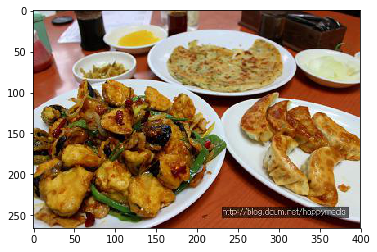

In [9]:
show_random_image_in_train_set("가지볶음")

### b) Data augmentation

이미지 분류에서 Overfitting을 막기 위한 방법으로, 모델에 넣을 때 이미지를 random하게 변형시키는 것

#### Data augmentation 되는 예시

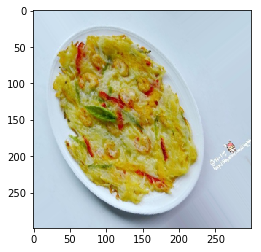

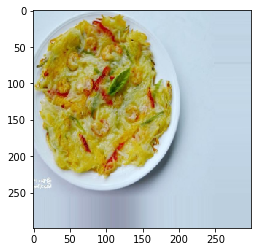

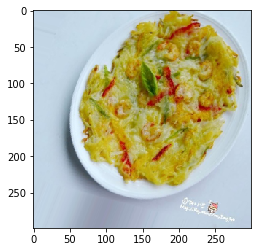

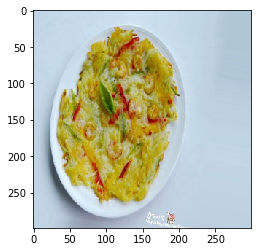

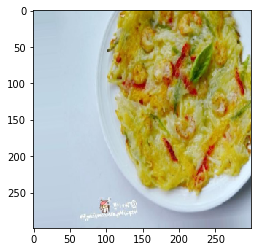

In [10]:
# 실행 시마다 parameter 범위 내에서 random하게 그림이 변형되므로 다른 변형된 그림들이 나타남

%matplotlib inline
sample_img_path = '/home/ec2-user/SageMaker/food_data/train/감자전/7_0102.jpg'

img = image.load_img(sample_img_path, target_size = (299, 299))

datagen = ImageDataGenerator(
    rotation_range=40,  # Int. Degree range for random rotations.
    width_shift_range=0.2, # float: fraction of total width
    height_shift_range=0.2, # float: fraction of total height
    shear_range=0.2, # Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    zoom_range=0.2, # Float or [lower, upper]. Range for random zoom.
    horizontal_flip=True,
    fill_mode='nearest'
)

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 5 == 0:
        break # break 하지 않으면 generator 는 무한히 반복됨

plt.show()

### Generator를 사용한 이미지 전처리

<br>
* 중요) train_datagen에 대해서만 augmentation을 수행한다!

generator를 사용하지 않으면 이미지 행렬이 모두 메모리 상에 올라가기 때문에 메모리 부족 현상이 발생할 수 있지만,

<b>generator는 연산에 사용되는 부분만 메모리에 올리기 때문에 메모리 효율적이다!</b>

In [11]:
# 이미지의 각 픽셀을 255로 나눠주는 것은 필수!

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale = 1./255) # 검증, 테스트 데이터는 augmentation 하면 안됨!
test_datagen = ImageDataGenerator(rescale= 1./255) 

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (299, 299),
    batch_size = 32, # gpu 연산 -> 2의 거듭제곱꼴로 맞추는 것이 좋다고 함
    seed = 42
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (299, 299),
    batch_size = 32, # gpu 연산 -> 2의 거듭제곱꼴로 맞추는 것이 좋다고 함
    shuffle=True,
    seed = 42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (299, 299),
    batch_size = 32, # gpu 연산 -> 2의 거듭제곱꼴로 맞추는 것이 좋다고 함
    seed = 42
)

Found 119234 images belonging to 150 classes.
Found 14982 images belonging to 150 classes.
Found 15517 images belonging to 150 classes.


In [12]:
# generator 출력 살펴보기
for data_batch, labels_batch in train_generator:
    print("배치 데이터 크기 : ", data_batch.shape)
    print("배치 레이블 크기 : ", labels_batch.shape)
    break

배치 데이터 크기 :  (32, 299, 299, 3)
배치 레이블 크기 :  (32, 150)


In [13]:
# generator의 길이
len(train_generator)

3727

## 4) InceptionV3 모델을 활용한 한식 이미지 분류 CNN 모델 만들기

<br>

- imagenet parameter로 훈련되어 있는 inceptionV3 모델에서 맨 위의 층을 제거한 후, <br>
Averagepooling2D 층, flatten 층, softmax 층을 추가해 모델을 구성함

<br>

- sagemaker p3.xlarge instance 사용
(GPU : 1xV100 16GB, CPU : 8cores, RAM 61GB)

<br>

###  InceptionV3 모델 구조

![title](images/inceptionV3_structure.png)

출처 : https://medium.com/@sh.tsang/review-inception-v3-1st-runner-up-image-classification-in-ilsvrc-2015-17915421f77c

<br>

###  CNN 모델간 성능 비교

![title](images/comparemodels.png)

<br>
출처 : https://keras.io/applications/

#### a) 사용 가능한 자원 (GPU, CPU) 확인

In [14]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13888570049731137700
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15595618304
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18025671088561396149
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0"
]


#### b) 파일 저장 경로 설정

In [15]:
# 모델 저장 경로 설정

from datetime import datetime

today = datetime.today()      # 현재 일 가져오기

date ='{}.{}.{}.{}h'.format(today.year, today.month, today.day, today.hour)
date

MODEL_SAVE_FOLDER_PATH = '/home/ec2-user/SageMaker/model/{}/'.format(date)

if not(os.path.isdir(MODEL_SAVE_FOLDER_PATH)):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + '결과 : {epoch:02d}-{val_acc:.4f}.hdf5'
print(model_path)

/home/ec2-user/SageMaker/model/2019.2.11.0h/결과 : {epoch:02d}-{val_acc:.4f}.hdf5


#### c) InceptionV3 모델에 image_generator 투입

- 원래 InceptionV3 층에서 마지막 층을 빼고 AveragePooling, Dropout, Flatten, Dropout, softmax 층을 추가! 

In [16]:
K.clear_session()

with K.tf.device('/device:GPU:0'): # gpu 사용
    # create the base pre-trained model
    base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))

    x = base_model.output
    x = AveragePooling2D(pool_size=(8, 8))(x)
    x = Dropout(.4)(x)
    x = Flatten()(x)
    x = Dropout(.4)(x)
    predictions = Dense(150,init='glorot_uniform', 
                        W_regularizer=l2(.0005), activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    
    opt = SGD(lr=.01, momentum=.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10) # 조기종료 콜백함수 정의
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_acc',
                               verbose=1, save_best_only=True) # 체크포인트 저장


87916544/87910968 [==============================] - 12s 0us/step


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(150, activation="softmax", kernel_initializer="glorot_uniform", kernel_regularizer=<keras.reg...)`


In [17]:
# lr_scheduler : epoch 증가함에 따라 learning_rate를 작게 해 cosf_function이 최적값 주변에서 맴도는 것을 완화!

def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 28:
        return .002
    else:
        return .0004
lr_scheduler = LearningRateScheduler(schedule)

In [77]:
history2 = model.fit_generator(train_generator,
                    epochs=30, steps_per_epoch= len(train_generator), 
                   validation_data = val_generator,
                   validation_steps= len(val_generator),
                    use_multiprocessing=True,
                    callbacks=[cb_checkpoint, early_stopping, lr_scheduler]
                    )

Epoch 1/30
3727/3727 [==============================] - 3284s 881ms/step - loss: 2.2770 - acc: 0.4664 - val_loss: 2.1568 - val_acc: 0.4957

Epoch 00001: val_acc improved from -inf to 0.49566, saving model to /home/ec2-user/SageMaker/model/2019.2.4.12h/결과 : 01-0.4957.hdf5
Epoch 2/30
3727/3727 [==============================] - 3265s 876ms/step - loss: 1.5192 - acc: 0.6385 - val_loss: 1.5874 - val_acc: 0.6310

Epoch 00002: val_acc improved from 0.49566 to 0.63102, saving model to /home/ec2-user/SageMaker/model/2019.2.4.12h/결과 : 02-0.6310.hdf5
Epoch 3/30
3727/3727 [==============================] - 3265s 876ms/step - loss: 1.2906 - acc: 0.6933 - val_loss: 1.6788 - val_acc: 0.6169

Epoch 00003: val_acc did not improve from 0.63102
Epoch 4/30
3727/3727 [==============================] - 3277s 879ms/step - loss: 1.1415 - acc: 0.7318 - val_loss: 1.2153 - val_acc: 0.7169

Epoch 00004: val_acc improved from 0.63102 to 0.71693, saving model to /home/ec2-user/SageMaker/model/2019.2.4.12h/결과 : 04-

In [78]:
# train_acc
print("train_acc ===", history2.history['acc'])

train_acc === [0.46636865323649296, 0.6385846319002969, 0.6934599191505778, 0.731989197712062, 0.754843417146116, 0.7738312897327944, 0.7914688763272221, 0.8066994313702467, 0.8197326265997954, 0.8298304174983646, 0.8393075800526696, 0.8491621517352433, 0.8577335323817032, 0.8662713655500948, 0.8747337168928326, 0.9250213865172686, 0.9387926262643206, 0.9462904876125937, 0.9507942365432679, 0.9553650804300786, 0.9574869584179009, 0.9603804284012949, 0.9628461680393177, 0.9637100155995773, 0.9663938138450442, 0.9685492393109348, 0.9697401747823607, 0.9722730093765202, 0.9766677290034722, 0.9775399634332489]


In [79]:
# val_acc
print("val_acc ===", history2.history['val_acc'])

val_acc === [0.4956614604191697, 0.631023895341076, 0.616873581623334, 0.7169269790454948, 0.6973701775384321, 0.7508343345268182, 0.7695901748765185, 0.7782672540381792, 0.77386196768661, 0.7639167000320912, 0.7627152583179287, 0.7771993058416239, 0.7982245361179555, 0.726271525838954, 0.8028968095047391, 0.8574289146976372, 0.8665732211987719, 0.8651047924175678, 0.8644373247817909, 0.8651047924175678, 0.8631691362889328, 0.8693098384648772, 0.8687091175998392, 0.8661727406300367, 0.8669737017675071, 0.8680416499720192, 0.866506474428033, 0.8608329995995194, 0.8710452542972094, 0.8709117607796022]


#### d) epoch에 따른 Training, validation loss, accuracy 그래프 

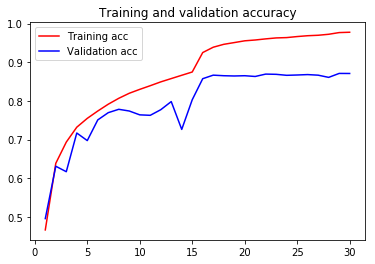

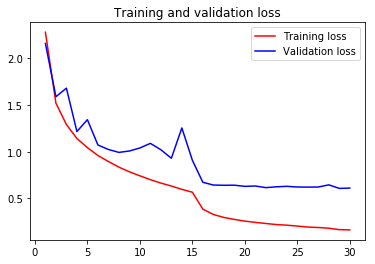

In [80]:
import matplotlib.pyplot as plt

acc = history2.history['acc']
val_acc = history2.history['val_acc']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label="Training acc")
plt.plot(epochs, val_acc, 'b', label="Validation acc")
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.title('Training and validation loss')
plt.legend()

plt.show()


#### e) model summary

In [82]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

#### 6) h5 확장자 형태로 모델을 저장

- sagemaker 인스턴스 stop 후에도 모델을 불러와 사용이 가능하다!

In [117]:
model.save('0206_InceptionV3 model.h5')

#### 7) 모델 불러오기

In [20]:
from keras.models import load_model
model = load_model('0206_InceptionV3 model.h5')

### 5) validation set에서 모델 평가 (기준 : accuracy, confusion_matrix 시각화)

- validation set의 accuracy 87.1%

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix

In [22]:
# 검증 셋으로 predict를 할 때, shuffle=False로 지정해야 섞이지 않은 상태에서 
# 실젯값과 예측값을 비교할 수 있다.

val_generator2 = val_datagen.flow_from_directory(
    val_dir,
    target_size = (299, 299),
    batch_size = 32, # gpu 연산 -> 2의 거듭제곱꼴로 맞추는 것이 좋다고 함
    shuffle=False,
    seed = 42
)
val_prediction = model.predict_generator(val_generator2, steps = len(val_generator2))

Found 14982 images belonging to 150 classes.


In [23]:
# 각 index별 음식 이름
food_classes = val_generator2.class_indices
print(food_classes)

{'가지볶음': 0, '간장게장': 1, '갈비구이': 2, '갈비찜': 3, '갈비탕': 4, '갈치구이': 5, '갈치조림': 6, '감자전': 7, '감자조림': 8, '감자채볶음': 9, '감자탕': 10, '갓김치': 11, '건새우볶음': 12, '경단': 13, '계란국': 14, '계란말이': 15, '계란찜': 16, '계란후라이': 17, '고등어구이': 18, '고등어조림': 19, '고사리나물': 20, '고추장진미채볶음': 21, '고추튀김': 22, '곰탕_설렁탕': 23, '곱창구이': 24, '곱창전골': 25, '과메기': 26, '김밥': 27, '김치볶음밥': 28, '김치전': 29, '김치찌개': 30, '김치찜': 31, '깍두기': 32, '깻잎장아찌': 33, '꼬막찜': 34, '꽁치조림': 35, '꽈리고추무침': 36, '꿀떡': 37, '나박김치': 38, '누룽지': 39, '닭갈비': 40, '닭계장': 41, '닭볶음탕': 42, '더덕구이': 43, '도라지무침': 44, '도토리묵': 45, '동그랑땡': 46, '동태찌개': 47, '된장찌개': 48, '두부김치': 49, '두부조림': 50, '땅콩조림': 51, '떡갈비': 52, '떡국_만두국': 53, '떡꼬치': 54, '떡볶이': 55, '라면': 56, '라볶이': 57, '막국수': 58, '만두': 59, '매운탕': 60, '멍게': 61, '메추리알장조림': 62, '멸치볶음': 63, '무국': 64, '무생채': 65, '물냉면': 66, '물회': 67, '미역국': 68, '미역줄기볶음': 69, '배추김치': 70, '백김치': 71, '보쌈': 72, '부추김치': 73, '북엇국': 74, '불고기': 75, '비빔냉면': 76, '비빔밥': 77, '산낙지': 78, '삼겹살': 79, '삼계탕': 80, '새우볶음밥': 81, '새우튀김': 82, '생선전': 83, '소세지볶음': 84, '송편': 85, '수육

In [24]:
# y가 예측한 레이블
val_y_pred = np.argmax(val_prediction, axis = 1)
# 실제 y 값
val_y_true = val_generator2.classes

print("val_y_pred ===  ", val_y_pred[:50])
print("val_y_true ===  ", val_y_true[:50])


val_y_pred ===   [  0   0   0   0   0   0   0   0   0   0   0   0   0 108   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0  36   0   0   0   0   0   0   0   0   0]
val_y_true ===   [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [25]:
# confusion_matrix
food_confusion_matrix = confusion_matrix(val_y_true, val_y_pred)
print(food_confusion_matrix)
print("shape==", food_confusion_matrix.shape)

[[93  0  0 ...  0  0  0]
 [ 0 91  0 ...  0  0  1]
 [ 0  0 83 ...  0  0  0]
 ...
 [ 0  0  0 ... 57  0  1]
 [ 0  0  0 ...  0 90  0]
 [ 0  0  0 ...  0  0 79]]
shape== (150, 150)


### confusion matrix 시각화 

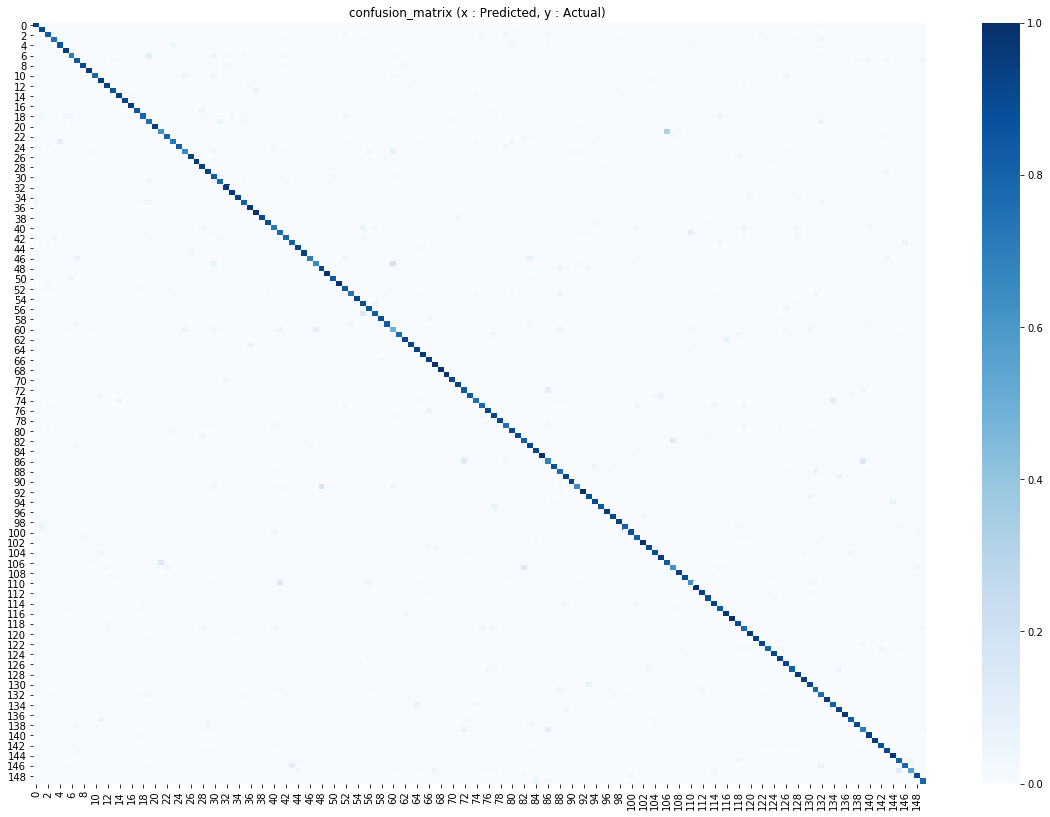

In [26]:
import seaborn as sns
import pandas as pd

# 단순히 갯수로 비교하면 이미지가 많은 클래스가 상대적으로 나쁘게 보일 수 있다.
# 현재 validation set의 class별 이미지 갯수는 전처리 과정에서 일부 누락된 게 있어 모두 100개가 아님
# --> 비율로 confusion_matrix를 normalize한다!

row_sums = food_confusion_matrix.sum(axis=1, keepdims=True)
norm_conf_mx = food_confusion_matrix / row_sums

df_cm = pd.DataFrame(norm_conf_mx, index = range(150),columns=range(150))

plt.figure(figsize = (20,14))
plt.title("confusion_matrix (x : Predicted, y : Actual) ")

sns.heatmap(df_cm, annot=False, cmap="Blues")

#### confusion_matrix에서 상대적으로 잘 분류된 음식과 그렇지 않은 음식 확인하기

In [28]:
# food_dict -> key : 음식 이름, value : index인 dictionary
food_dict = val_generator2.class_indices
# foods_prob : (음식 이름, 음식의 index, 예측값=실제값일 확률)인 tuple을 각 원소로 갖는 list
foods_prob = [(food_name,idx, prob) for food_name, idx, prob in zip(food_dict.keys(), food_dict.values() ,np.diag(norm_conf_mx))]
foods_prob =  sorted(foods_prob,key= lambda x : x[2])
print(foods_prob)


[('매운탕', 60, 0.49), ('회무침', 147, 0.57), ('오징어튀김', 107, 0.62), ('고추장진미채볶음', 21, 0.63), ('육개장', 110, 0.63), ('순두부찌개', 91, 0.65), ('동태찌개', 47, 0.66), ('곱창전골', 25, 0.67), ('수육', 86, 0.68), ('갈치조림', 6, 0.71), ('동그랑땡', 46, 0.71), ('편육', 139, 0.71), ('닭갈비', 40, 0.72), ('곰탕_설렁탕', 23, 0.73), ('떡국_만두국', 53, 0.74), ('갈비찜', 3, 0.75), ('고등어조림', 19, 0.75), ('북엇국', 74, 0.76), ('삼겹살', 79, 0.76), ('코다리조림', 132, 0.76), ('수제비', 88, 0.7628865979381443), ('닭계장', 41, 0.77), ('멍게', 61, 0.77), ('제육볶음', 119, 0.77), ('감자탕', 10, 0.79), ('고등어구이', 18, 0.79), ('김치찜', 31, 0.79), ('닭볶음탕', 42, 0.79), ('불고기', 75, 0.79), ('황태구이', 146, 0.79), ('훈제오리', 149, 0.79), ('고추튀김', 22, 0.8), ('주꾸미볶음', 123, 0.8), ('칼국수', 131, 0.8), ('더덕구이', 43, 0.81), ('양념게장', 99, 0.81), ('홍어무침', 145, 0.81), ('곱창구이', 24, 0.82), ('꽁치조림', 35, 0.82), ('새우튀김', 82, 0.82), ('어묵볶음', 101, 0.82), ('쫄면', 127, 0.82), ('콩나물국', 134, 0.82), ('갈비구이', 2, 0.83), ('라볶이', 57, 0.83), ('만두', 59, 0.83), ('파김치', 137, 0.83), ('감자전', 7, 0.84), ('김치찌개', 30, 0.84), ('두부조림', 

In [29]:
# 잘 분류될 확률이 60% 이하인 음식들
bad_classfifed_foods = [food_prob for food_prob in foods_prob if food_prob[2] <= 0.6 ]
bad_classfifed_foods

[('매운탕', 60, 0.49), ('회무침', 147, 0.57)]

In [30]:
# 2차원 numpy 행렬의 각 행의 최댓값을 제거한 후 리스트에 추가하는 함수
# ex) arr = np.array([[100, 103, 102], [104, 105, 102]])
#    -> return 값 : [array([100, 102]), array([104, 102])]

# def remove_max_values_in_array(arr):
#     new_arr = []
#     for i, each in enumerate(arr):
#         max_idr = np.argwhere(each == np.max(each))
#         each = np.delete(each, max_idr)
#         new_arr.append(each)
#     return new_arr
    
    

In [31]:
# bad_classified_foods 에 속하는 각 음식이 어떤 음식으로 가장 오분류 되었는지 확인
# misunderstand_foods_idx -> 잘 못 분류된 각 음식에서, 가장 오분류된 음식의 index를 담는 list

# bad_idx = [each[1] for each in bad_classfifed_foods]

# temp = 

# misunderstand_foods_idx = [np.argmax(array) for idx, array in enumerate(norm_conf_mx.T) if idx in bad_idx]

# misunderstand_foods = [each[0] for each in foods_prob if each[1] in misunderstand_foods_idx]


# # final_dict -> key : 잘 못 분류된 각 음식, value : 가장 오분류된 음식 인 dictionary
# final_dict = {bad_classified_food[0] : misunderstand_food for bad_classified_food, misunderstand_food
#                                                             in zip(bad_classfifed_foods, misunderstand_foods)}


## 6) test set에서의 loss, accuracy 확인!

### -> test_accuracy 90.0% 확인!

In [32]:
test_loss, test_acc = model.evaluate_generator(test_generator,steps= len(test_generator), use_multiprocessing=True, verbose=2)
# loss, acc 출력
print("loss, acc ===", test_loss, test_acc)

loss, acc === 0.48087751482798663 0.8995939937266


## 7) h5 model을 tflite 모델로 변환

<br>
* keras h5 model을 앱에 싣기 위해 tflite 모델로 변환

In [ ]:
# import tensorflow as tf

# # hr
# converter = tf.contrib.lite.TocoConverter.from_keras_model_file("0206_InceptionV3 model.h5")
# tf_lite_model = converter.convert()

# file = open('tf_lite_model1.tflite', 'wb')
# file.write(tf_lite_model)

## 8) FireBase에 모델 올릴 때 용량 제한 문제 발생

<br>

### FireBase : 구글에서 제공하는 모바일 앱 개발 시 회원 인증, 머신러닝 모델 연동, DB, 저장소 기능 등을 쉽게 사용할 수 있게 해주는 툴

- FireBase의 MLkit을 사용하면, 딥러닝 모델을 스마트폰 기기에 직접 실어 추론 기능을 수행하도록 할 수 있음

-----

- 그런데, 아래 캡처와 같이 <b>용량 초과</b> 문제로 MLkit과 InceptionV3 모델 연동이 불가능함


- 두 가지 선택지 존재 
 > 1. MLkit을 사용 하지 않고. 딥러닝 모델은 서버에 놓은 상태에서 REST API 통신을 하는 방식
 
 > 2. MLkit에 적용할 수 있도록 저 용량의 딥러닝 모델을 새로 만드는 방식
 
 ####  ----> 2번 방식을 택하기로 함!

![title](images/FireBase_size_problem.PNG)

## 9) 가벼운 용량의 MobileNetV2 모델로 (4, 5, 6, 7 과정 재 수행)

<br>

- imagenet parameter로 훈련되어 있는 inceptionV3 모델에서 마지막 두 층을 제거한 후, softmax 층을 추가해 모델을 구성함

- sagemaker p3.xlarge instance 사용
(GPU : 1xV100 16GB, CPU : 8cores, RAM 61GB)

<br>

### MobileNetV2 모델 구조 
![title](images/MobileNetV2_structure.png)

출처 : http://openaccess.thecvf.com/content_cvpr_2018/papers/Sandler_MobileNetV2_Inverted_Residuals_CVPR_2018_paper.pdf


### a) MobileNetV2 모델 구성 코드 

In [33]:
# InceptionV3 모델에서는 299 * 299 pixel 사용
# MoblieNEtV2 모델에서는 224 * 224 pixel 사용!
train_dir =  '/home/ec2-user/SageMaker/food_data/train'
val_dir =  '/home/ec2-user/SageMaker/food_data/validation'
test_dir = '/home/ec2-user/SageMaker/food_data/test'

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale = 1./255) # 검증, 테스트 데이터는 augmentation 하면 안됨!
test_datagen = ImageDataGenerator(rescale= 1./255) 

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224, 224),
    batch_size = 64, # gpu 연산 -> 2의 거듭제곱꼴로 맞추는 것이 좋다고 함
    seed = 42
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (224, 224),
    batch_size = 64, # gpu 연산 -> 2의 거듭제곱꼴로 맞추는 것이 좋다고 함
    seed = 42,
    shuffle= False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (224, 224),
    batch_size = 64, # gpu 연산 -> 2의 거듭제곱꼴로 맞추는 것이 좋다고 함
    seed = 42
)

Found 119234 images belonging to 150 classes.
Found 14982 images belonging to 150 classes.
Found 15517 images belonging to 150 classes.


In [34]:
K.clear_session()

with K.tf.device('/device:GPU:0'): # gpu 사용
    # create the base pre-trained model
    base_model = MobileNetV2()

    x = base_model.layers[-2].output
    predictions = Dense(150,init='glorot_uniform', 
                        W_regularizer=l2(.0005), activation='softmax')(x)

    # this is the model we will train
    mobile_model = Model(inputs=base_model.input, outputs=predictions)
    
    opt = SGD(lr=.01, momentum=.9)
    mobile_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10) # 조기종료 콜백함수 정의
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_acc',
                               verbose=1, save_best_only=True) # 체크포인트 저장

def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 28:
        return .002
    else:
        return .0004
    
lr_scheduler = LearningRateScheduler(schedule)

# history2 = mobile_model.fit_generator(train_generator,
#                     epochs=30, steps_per_epoch= len(train_generator), 
#                    validation_data = val_generator,
#                    validation_steps= len(val_generator),
#                     use_multiprocessing=True,
#                     callbacks=[cb_checkpoint, early_stopping, lr_scheduler]
#                     )

In [38]:
# 모델 불러오기
from keras.models import load_model
mobile_model = load_model('190208_MobileNetV2.h5')

### b) validation set에서 모델 평가 (기준 : accuracy, confusion_matrix)

In [35]:
# print('train_acc ===== ', history2.history['acc'])
# print('val_acc ===== ', history2.history['val_acc'])

train_acc = [0.5262089672408876, 0.6750842880386467, 0.720717245081101, 0.7488048710938155, 0.769008839760471, 
                  0.7876947850445343, 0.8011053894023517, 0.8118070349061509, 0.821686767197276, 0.8303587902779409, 
                  0.8377979435395944, 0.8473757485281044, 0.8523743227602865, 0.859603804284013, 0.8641578744317896, 
                  0.91667645134777, 0.927956790848248, 0.9331566499488401, 0.9373668584464163, 0.9399751748662294,
                  0.9421138265930858, 0.9444369894493182, 0.946122750222252, 0.9479846352550447, 0.9497626515926665, 
                  0.9508110102823021, 0.9534696479192176, 0.9546102621735411, 0.9608668668332858]
val_acc = [0.22987585102321467, 0.24783073020958485, 0.29395274329393956, 0.48538245895869775, 0.5821652649766914, 
                0.6287545054064878, 0.6674676278120939, 0.6344279802509151, 0.7067147243279128, 0.6401682018342538, 0.7193966092644507, 
                0.6611934321105855, 0.7053797890881864, 0.6474435989894276, 0.7081164063542918, 0.8095714857908963, 0.8101722066479776, 
                0.8102389534028027, 0.8223868642370845, 0.8238552930182886, 0.8178480843599514, 0.8155119476625812, 0.816179415298358, 
                0.8003604325269796, 0.8208516886930984, 0.8171138699773061, 0.816312908823922, 0.8125750901081298, 0.8213189160325725]


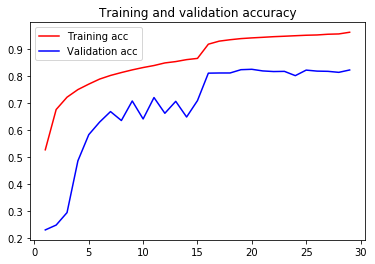

<Figure size 432x288 with 0 Axes>

In [36]:
%matplotlib inline

import matplotlib.pyplot as plt

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'r', label="Training acc")
plt.plot(epochs, val_acc, 'b', label="Validation acc")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.show()

In [40]:
# 모델 요약
mobile_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
__________________________________________________________________________________________________
expanded_c

#### confusion matrix 시각화

In [41]:
val_prediction = mobile_model.predict_generator(val_generator, steps = len(val_generator))

In [42]:
import numpy as np
from sklearn.metrics import confusion_matrix

# y가 예측한 레이블
val_y_pred = np.argmax(val_prediction, axis = 1)
# 실제 y 값
val_y_true = val_generator.classes

print("val_y_pred ===  ", val_y_pred[:50])
print("val_y_true ===  ", val_y_true[:50])

# confusion_matrix
food_confusion_matrix = confusion_matrix(val_y_true, val_y_pred)
print(food_confusion_matrix)
print("shape==", food_confusion_matrix.shape)


val_y_pred ===   [  0   0   0   0   0   0   0   0   0   0   0   0   0 108 136   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 128   0
   0   0   0   0  36   0   0   0   0   0   0  35  36   0]
val_y_true ===   [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[88  0  0 ...  0  0  0]
 [ 0 87  0 ...  0  0  0]
 [ 0  0 74 ...  0  0  0]
 ...
 [ 0  0  0 ... 36  0  3]
 [ 0  0  0 ...  0 88  0]
 [ 0  0  1 ...  0  0 78]]
shape== (150, 150)


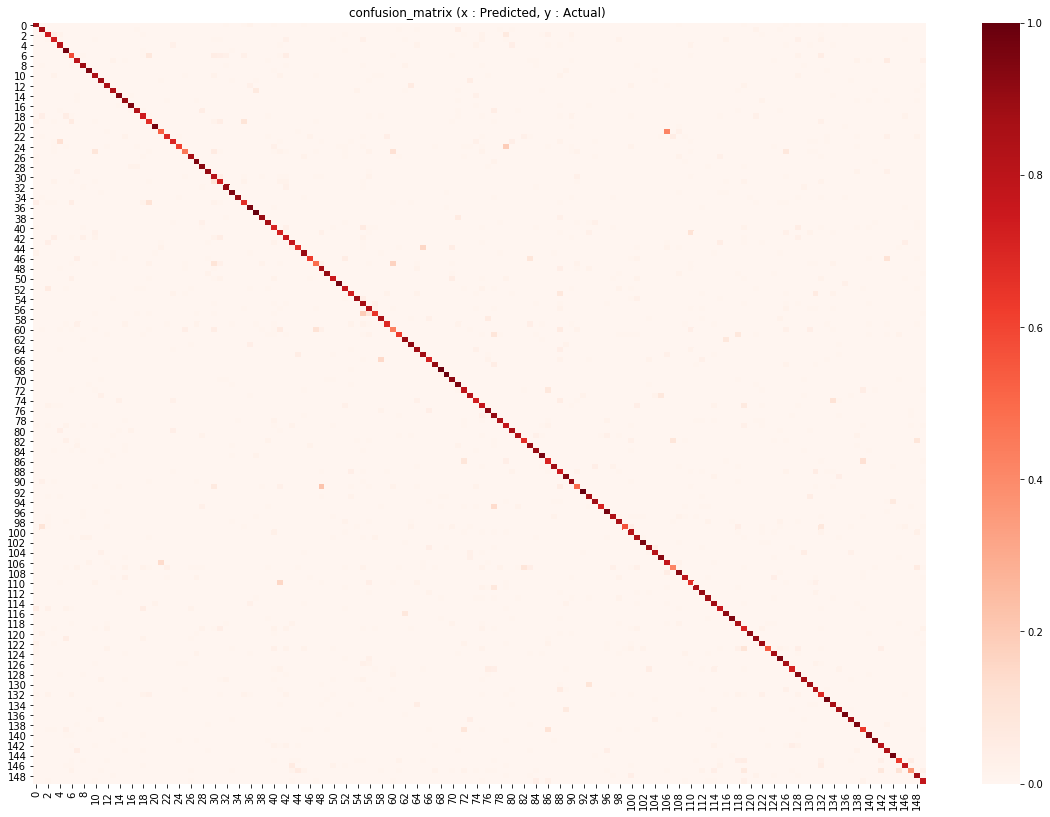

In [43]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# 단순히 갯수로 비교하면 이미지가 많은 클래스가 상대적으로 나쁘게 보일 수 있다.
# 현재 validation set의 class별 이미지 갯수는 전처리 과정에서 일부 누락된 게 있어 모두 100개가 아님
# --> 비율로 confusion_matrix를 normalize한다!

row_sums = food_confusion_matrix.sum(axis=1, keepdims=True)
norm_conf_mx = food_confusion_matrix / row_sums

df_cm = pd.DataFrame(norm_conf_mx, index = range(150),columns=range(150))

plt.figure(figsize = (20,14))
plt.title("confusion_matrix (x : Predicted, y : Actual) ")

sns.heatmap(df_cm, annot=False, cmap="Reds")

#### confusion_matrix에서 상대적으로 잘 분류된 음식과 그렇지 않은 음식 확인하기

In [45]:
# food_dict -> key : 음식 이름, value : index인 dictionary
food_dict = val_generator.class_indices
# foods_prob : (음식 이름, 음식의 index, 예측값=실제값일 확률)인 tuple을 각 원소로 갖는 list
foods_prob = [(food_name,idx, prob) for food_name, idx, prob in zip(food_dict.keys(), food_dict.values() ,np.diag(norm_conf_mx))]
foods_prob =  sorted(foods_prob,key= lambda x : x[2])
print(foods_prob)

[('회무침', 147, 0.36), ('오징어튀김', 107, 0.42), ('매운탕', 60, 0.43), ('곱창전골', 25, 0.46), ('동태찌개', 47, 0.49), ('순두부찌개', 91, 0.5), ('고추장진미채볶음', 21, 0.53), ('주꾸미볶음', 123, 0.54), ('양념게장', 99, 0.57), ('갈치조림', 6, 0.58), ('곱창구이', 24, 0.61), ('동그랑땡', 46, 0.63), ('멍게', 61, 0.63), ('편육', 139, 0.64), ('홍어무침', 145, 0.64), ('라볶이', 57, 0.65), ('고등어조림', 19, 0.67), ('꽁치조림', 35, 0.67), ('도라지무침', 44, 0.67), ('새우튀김', 82, 0.67), ('육개장', 110, 0.67), ('고추튀김', 22, 0.69), ('만두', 59, 0.69), ('코다리조림', 132, 0.69), ('곰탕_설렁탕', 23, 0.7), ('닭갈비', 40, 0.71), ('수육', 86, 0.71), ('알밥', 95, 0.71), ('제육볶음', 119, 0.71), ('닭계장', 41, 0.72), ('물냉면', 66, 0.72), ('쫄면', 127, 0.72), ('갈비찜', 3, 0.73), ('김치찜', 31, 0.73), ('떡국_만두국', 53, 0.73), ('북엇국', 74, 0.73), ('갈비구이', 2, 0.74), ('고등어구이', 18, 0.74), ('수제비', 88, 0.7422680412371134), ('두부조림', 50, 0.75), ('닭볶음탕', 42, 0.76), ('떡갈비', 52, 0.77), ('불고기', 75, 0.77), ('장어구이', 115, 0.77), ('더덕구이', 43, 0.78), ('삼겹살', 79, 0.78), ('오징어채볶음', 106, 0.78), ('훈제오리', 149, 0.78), ('보쌈', 72, 0.79), ('황태구이', 

In [46]:
# 잘 분류될 확률이 60% 이하인 음식 확인
bad_classfifed_foods = [food_prob for food_prob in foods_prob if food_prob[2] <= 0.6 ]
bad_classfifed_foods

[('회무침', 147, 0.36),
 ('오징어튀김', 107, 0.42),
 ('매운탕', 60, 0.43),
 ('곱창전골', 25, 0.46),
 ('동태찌개', 47, 0.49),
 ('순두부찌개', 91, 0.5),
 ('고추장진미채볶음', 21, 0.53),
 ('주꾸미볶음', 123, 0.54),
 ('양념게장', 99, 0.57),
 ('갈치조림', 6, 0.58)]

### InceptionV3, MobileNetV2 모델의 음식별 정확도 히스토그램

<br>

- Validation set에서 accuracy는 <b> InceptionV3가 87.1%, MobileNetV2가 82.4% </b>로 약 5%의 차이가 존재함

<br>

#### 개별 음식의 정확도를 비교하면 두 모델의 차이가 더 큼을 확인할 수 있음

<br>

- 개별 음식별 정확도의 분포를 보면 inceptionV3 모델의 <b>정확도 분포가 더 오른쪽으로 치우쳐있음

<br>

- MobileNetV2 층의 정확도 분포는 <b>더 고르고 왼쪽으로 길게 꼬리가 형성</b>되어 있음


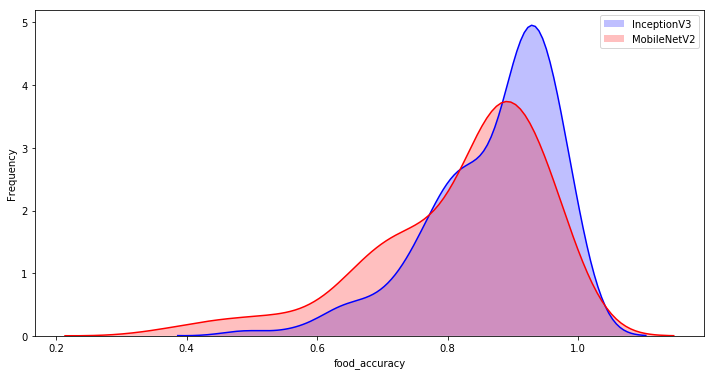

In [43]:
from matplotlib import pyplot as plt
import seaborn as sns

inceptionV3_foods_prob = [('매운탕', 60, 0.49), ('회무침', 147, 0.57), ('오징어튀김', 107, 0.62), ('고추장진미채볶음', 21, 0.63), ('육개장', 110, 0.63), ('순두부찌개', 91, 0.65), ('동태찌개', 47, 0.66), ('곱창전골', 25, 0.67), ('수육', 86, 0.68), ('갈치조림', 6, 0.71), ('동그랑땡', 46, 0.71), ('편육', 139, 0.71), ('닭갈비', 40, 0.72), ('곰탕_설렁탕', 23, 0.73), ('떡국_만두국', 53, 0.74), ('갈비찜', 3, 0.75), ('고등어조림', 19, 0.75), ('북엇국', 74, 0.76), ('삼겹살', 79, 0.76), ('코다리조림', 132, 0.76), ('수제비', 88, 0.7628865979381443), ('닭계장', 41, 0.77), ('멍게', 61, 0.77), ('제육볶음', 119, 0.77), ('감자탕', 10, 0.79), ('고등어구이', 18, 0.79), ('김치찜', 31, 0.79), ('닭볶음탕', 42, 0.79), ('불고기', 75, 0.79), ('황태구이', 146, 0.79), ('훈제오리', 149, 0.79), ('고추튀김', 22, 0.8), ('주꾸미볶음', 123, 0.8), ('칼국수', 131, 0.8), ('더덕구이', 43, 0.81), ('양념게장', 99, 0.81), ('홍어무침', 145, 0.81), ('곱창구이', 24, 0.82), ('꽁치조림', 35, 0.82), ('새우튀김', 82, 0.82), ('어묵볶음', 101, 0.82), ('쫄면', 127, 0.82), ('콩나물국', 134, 0.82), ('갈비구이', 2, 0.83), ('라볶이', 57, 0.83), ('만두', 59, 0.83), ('파김치', 137, 0.83), ('감자전', 7, 0.84), ('김치찌개', 30, 0.84), ('두부조림', 50, 0.84), ('보쌈', 72, 0.84), ('부추김치', 73, 0.84), ('오징어채볶음', 106, 0.84), ('장어구이', 115, 0.84), ('계란후라이', 17, 0.85), ('떡갈비', 52, 0.85), ('알밥', 95, 0.85), ('갈비탕', 4, 0.86), ('경단', 13, 0.86), ('라면', 56, 0.86), ('양념치킨', 100, 0.8791208791208791), ('떡볶이', 55, 0.88), ('시래기국', 93, 0.88), ('열무김치', 104, 0.88), ('해물찜', 142, 0.88), ('누룽지', 39, 0.89), ('막국수', 58, 0.89), ('수정과', 87, 0.89), ('감자조림', 8, 0.9), ('된장찌개', 48, 0.9), ('산낙지', 78, 0.9), ('삼계탕', 80, 0.9), ('열무국수', 103, 0.9), ('유부초밥', 109, 0.9), ('잡곡밥', 113, 0.9), ('젓갈', 118, 0.9), ('후라이드치킨', 148, 0.9), ('간장게장', 1, 0.91), ('나박김치', 38, 0.91), ('새우볶음밥', 81, 0.91), ('식혜', 94, 0.91), ('약과', 97, 0.91), ('족발', 122, 0.91), ('추어탕', 130, 0.91), ('파전', 138, 0.91), ('호박전', 143, 0.91), ('비빔냉면', 76, 0.9183673469387755), ('계란말이', 15, 0.92), ('떡꼬치', 54, 0.92), ('메추리알장조림', 62, 0.92), ('멸치볶음', 63, 0.92), ('배추김치', 70, 0.92), ('비빔밥', 77, 0.92), ('생선전', 83, 0.92), ('소세지볶음', 84, 0.92), ('주먹밥', 124, 0.92), ('짬뽕', 126, 0.92), ('가지볶음', 0, 0.93), ('과메기', 26, 0.93), ('김치전', 29, 0.93), ('도라지무침', 44, 0.93), ('무국', 64, 0.93), ('숙주나물', 89, 0.93), ('순대', 90, 0.93), ('우엉조림', 108, 0.93), ('잡채', 114, 0.93), ('콩나물무침', 135, 0.93), ('건새우볶음', 12, 0.94), ('김치볶음밥', 28, 0.94), ('꼬막찜', 34, 0.94), ('도토리묵', 45, 0.94), ('물냉면', 66, 0.94), ('백김치', 71, 0.94), ('약식', 98, 0.94), ('잔치국수', 112, 0.94), ('조기구이', 121, 0.94), ('짜장면', 125, 0.94), ('갓김치', 11, 0.95), ('계란국', 14, 0.95), ('고사리나물', 20, 0.95), ('오이소박이', 105, 0.95), ('찜닭', 128, 0.95), ('피자', 140, 0.95), ('갈치구이', 5, 0.96), ('감자채볶음', 9, 0.96), ('계란찜', 16, 0.96), ('깍두기', 32, 0.96), ('무생채', 65, 0.96), ('총각김치', 129, 0.96), ('콩국수', 133, 0.96), ('김밥', 27, 0.97), ('깻잎장아찌', 33, 0.97), ('꽈리고추무침', 36, 0.97), ('애호박볶음', 96, 0.97), ('장조림', 116, 0.97), ('조개구이', 120, 0.97), ('콩자반', 136, 0.97), ('한과', 141, 0.97), ('호박죽', 144, 0.98), ('꿀떡', 37, 0.9895833333333334), ('두부김치', 49, 0.99), ('땅콩조림', 51, 0.99), ('물회', 67, 0.99), ('미역줄기볶음', 69, 0.99), ('송편', 85, 0.99), ('연근조림', 102, 0.99), ('육회', 111, 0.99), ('미역국', 68, 1.0), ('시금치나물', 92, 1.0), ('전복죽', 117, 1.0)]
mobileNetV2_foods_prob = [('회무침', 147, 0.36), ('오징어튀김', 107, 0.42), ('매운탕', 60, 0.43), ('곱창전골', 25, 0.46), ('동태찌개', 47, 0.49), ('순두부찌개', 91, 0.5), ('고추장진미채볶음', 21, 0.53), ('주꾸미볶음', 123, 0.54), ('양념게장', 99, 0.57), ('갈치조림', 6, 0.58), ('곱창구이', 24, 0.61), ('동그랑땡', 46, 0.63), ('멍게', 61, 0.63), ('편육', 139, 0.64), ('홍어무침', 145, 0.64), ('라볶이', 57, 0.65), ('고등어조림', 19, 0.67), ('꽁치조림', 35, 0.67), ('도라지무침', 44, 0.67), ('새우튀김', 82, 0.67), ('육개장', 110, 0.67), ('고추튀김', 22, 0.69), ('만두', 59, 0.69), ('코다리조림', 132, 0.69), ('곰탕_설렁탕', 23, 0.7), ('닭갈비', 40, 0.71), ('수육', 86, 0.71), ('알밥', 95, 0.71), ('제육볶음', 119, 0.71), ('닭계장', 41, 0.72), ('물냉면', 66, 0.72), ('쫄면', 127, 0.72), ('갈비찜', 3, 0.73), ('김치찜', 31, 0.73), ('떡국_만두국', 53, 0.73), ('북엇국', 74, 0.73), ('갈비구이', 2, 0.74), ('고등어구이', 18, 0.74), ('수제비', 88, 0.7422680412371134), ('두부조림', 50, 0.75), ('닭볶음탕', 42, 0.76), ('떡갈비', 52, 0.77), ('불고기', 75, 0.77), ('장어구이', 115, 0.77), ('더덕구이', 43, 0.78), ('삼겹살', 79, 0.78), ('오징어채볶음', 106, 0.78), ('훈제오리', 149, 0.78), ('보쌈', 72, 0.79), ('황태구이', 146, 0.79), ('감자전', 7, 0.8), ('유부초밥', 109, 0.8), ('갈비탕', 4, 0.81), ('열무김치', 104, 0.81), ('해물찜', 142, 0.81), ('김치찌개', 30, 0.82), ('부추김치', 73, 0.82), ('양념치킨', 100, 0.8241758241758241), ('계란후라이', 17, 0.83), ('라면', 56, 0.83), ('새우볶음밥', 81, 0.83), ('칼국수', 131, 0.83), ('경단', 13, 0.84), ('약과', 97, 0.84), ('호박전', 143, 0.84), ('감자탕', 10, 0.85), ('건새우볶음', 12, 0.85), ('산낙지', 78, 0.85), ('어묵볶음', 101, 0.85), ('육회', 111, 0.85), ('젓갈', 118, 0.85), ('과메기', 26, 0.86), ('막국수', 58, 0.86), ('삼계탕', 80, 0.86), ('약식', 98, 0.86), ('간장게장', 1, 0.87), ('누룽지', 39, 0.87), ('된장찌개', 48, 0.87), ('떡볶이', 55, 0.87), ('시래기국', 93, 0.87), ('주먹밥', 124, 0.87), ('짬뽕', 126, 0.87), ('총각김치', 129, 0.87), ('콩나물국', 134, 0.87), ('콩나물무침', 135, 0.87), ('가지볶음', 0, 0.88), ('무국', 64, 0.88), ('무생채', 65, 0.88), ('수정과', 87, 0.88), ('식혜', 94, 0.88), ('잡곡밥', 113, 0.88), ('잡채', 114, 0.88), ('추어탕', 130, 0.88), ('파김치', 137, 0.88), ('후라이드치킨', 148, 0.88), ('감자조림', 8, 0.89), ('갓김치', 11, 0.89), ('떡꼬치', 54, 0.89), ('열무국수', 103, 0.89), ('족발', 122, 0.89), ('계란말이', 15, 0.9), ('꼬막찜', 34, 0.9), ('나박김치', 38, 0.9), ('도토리묵', 45, 0.9), ('메추리알장조림', 62, 0.9), ('생선전', 83, 0.9), ('소세지볶음', 84, 0.9), ('순대', 90, 0.9), ('김치전', 29, 0.91), ('깍두기', 32, 0.91), ('두부김치', 49, 0.91), ('물회', 67, 0.91), ('비빔밥', 77, 0.91), ('잔치국수', 112, 0.91), ('조기구이', 121, 0.91), ('멸치볶음', 63, 0.92), ('배추김치', 70, 0.92), ('장조림', 116, 0.92), ('조개구이', 120, 0.92), ('비빔냉면', 76, 0.9285714285714286), ('김치볶음밥', 28, 0.93), ('오이소박이', 105, 0.93), ('우엉조림', 108, 0.93), ('찜닭', 128, 0.93), ('피자', 140, 0.93), ('계란국', 14, 0.94), ('숙주나물', 89, 0.94), ('한과', 141, 0.94), ('감자채볶음', 9, 0.95), ('계란찜', 16, 0.95), ('김밥', 27, 0.95), ('깻잎장아찌', 33, 0.95), ('백김치', 71, 0.95), ('전복죽', 117, 0.95), ('파전', 138, 0.95), ('꽈리고추무침', 36, 0.96), ('송편', 85, 0.96), ('연근조림', 102, 0.96), ('짜장면', 125, 0.96), ('갈치구이', 5, 0.97), ('고사리나물', 20, 0.97), ('땅콩조림', 51, 0.97), ('애호박볶음', 96, 0.97), ('콩국수', 133, 0.97), ('콩자반', 136, 0.97), ('호박죽', 144, 0.98), ('미역국', 68, 0.99), ('미역줄기볶음', 69, 0.99), ('꿀떡', 37, 1.0), ('시금치나물', 92, 1.0)]

inceptionV3_prob = [prob[2] for prob in inceptionV3_foods_prob]
mobileNetV2_prob = [prob[2] for prob in mobileNetV2_foods_prob]

f, ax = plt.subplots(figsize=(12, 6))
g = sns.kdeplot(inceptionV3_prob, ax=ax, color='Blue', shade=True)
g = sns.kdeplot(mobileNetV2_prob, ax=ax, color='Red', shade=True)
g.set_xlabel('Each food accuracy')
g.set_ylabel('Frequency')
g = g.legend(['InceptionV3', 'MobileNetV2'])


### c) test set에서 accuracy 최종 확인

In [47]:
# test set에서 평가
test_loss, test_acc = mobile_model.evaluate_generator(test_generator,steps= len(test_generator), use_multiprocessing=True, verbose=2)

In [48]:
# test set accuracy 확인 
test_acc

0.8513243539151883

#### h5 model -> tfLite model로 변환하는 코드

In [49]:
import tensorflow as tf

In [50]:
# 버전에 따라 변환하는 코드가 다름
tf.__version__

'1.10.0'

In [51]:
converter = tf.contrib.lite.TocoConverter.from_keras_model_file('190208_MobileNetV2.h5')
tf_lite_model = converter.convert()
file = open('190209_MobileNetV2.tflite', 'wb')
file.write(tf_lite_model)

### test set 정확도는 약 5% 더 부족하지만 FireBase와의 연동성을 고려해 MobileNetV2를 사용!

-------